### 신경써야 하는 것들

- 포커스를 어디다 둘꺼냐 범위를 얼마나 둘꺼냐 생각하기\
범위를 서울 인기 숙소? 실시간인기숙소 버튼 누르면 서울의 숙소 누른거랑 똑같이 나옴


- 수업내용을 잘 보여주고 있는지
- 분석에 의미가 있었으면 좋겠다.

In [81]:
import lxml.html
import requests
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options
import pandas as pd
from urllib.parse import urljoin

In [82]:
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from time import sleep
from sklearn.feature_extraction.text import TfidfTransformer
import time

하나씩 보려고 하는 것

한국의 실시간 인기 숙소 데이터 가져오기 20개

In [57]:
url='https://www.airbnb.co.kr/s/South-Korea/homes?place_id=ChIJm7oRy-tVZDURS9uIugCbJJE&landing_page_section=LISTING_CARDS'

In [58]:
res=requests.get(url)

In [59]:
root=lxml.html.fromstring(res.text)

상대적 url 이어서 절대적 url 로 바꿔줌

In [61]:
urls=[]
for link in root.cssselect('._gjfol0'):
    urls.append(urljoin(url,link.attrib['href']))

셀레늄 써서 전체화면으로 창 하나 띄우기

In [62]:
options = Options()
# chrome을 전체화면으로 넓히는 옵션입니다.
options.add_argument('--start-maximized')

# executable_path에는 chromedriver 실행 파일의 경로를 넣고, chrome_options에는 options 변수를 넣습니다.
browser = Chrome(executable_path='./chromedriver', chrome_options=options)

<ipython-input-62-b5333dea218a>:6: DeprecationWarning: use options instead of chrome_options
  browser = Chrome(executable_path='./chromedriver', chrome_options=options)


In [64]:
browser.get(urls[0])

사이트 들어가면 뜨는 쿠키설정 확인 버튼 누르기

In [65]:
cookie=browser.find_elements_by_css_selector('._1qnlffd6')

In [66]:
coo=cookie[0]

In [67]:
coo.click()

후기 모두 보기 누른 것

In [68]:
more_review=browser.find_elements_by_css_selector('div._19qg1ru a._13e0raay')

In [69]:
more_review

[<selenium.webdriver.remote.webelement.WebElement (session="d11e160f88a02a36a23564fb3b75add5", element="987af041-1f6a-4b48-9df2-9c5f173346a5")>]

In [70]:
a=0
if len(more_review)!= 0:
    a=0
    link=more_review[0]
    link.click()
else:
    a=1
    pass

스페이스바를 누르면 스크롤을 내리는데 처음에 바로 스페이스바를 누르면 후기창이 꺼진다.\
그래서 아무곳이나 클릭하는 것을 만든 것이다.

In [71]:
space=browser.find_elements_by_css_selector('div._16hs373 h2._14i3z6h')

In [72]:
if a!=0:
    pass
else:
    link=space[0]
    link.click()

스크롤 내리는 것을 스페이스바 누르는 것으로 실행하는 것이다. 2분정도 기다려야한다.

### 스크롤 내리는데 원래 다 내리면 멈춰야하는데 browser가 아니라 안멈추는 것 같아

In [75]:
if a!=0:
    pass
else:
    actions=ActionChains(browser)
    last_height=browser.execute_script('return document.body.scrollHeight')
    while(True):
        for _ in range(60):
            actions.send_keys(Keys.SPACE).perform()
            sleep(2)
        new_height=browser.execute_script('return document.body.scrollHeight')
        if new_height== last_height:
            break
        last_height= new_height

    print('loading complete')
    browser.execute_script('window.scrollTo(0,0);')
    sleep(3)

loading complete


더 읽기 버튼 누르기

In [76]:
more_read=browser.find_elements_by_css_selector('div._1gjypya button._ejra3kg')
more_people=browser.find_elements_by_css_selector('div._3j8fry div._1gjypya')

In [77]:
more_read

[]

### 이것을 실행하여도 스크롤이 올라가지 않습니다.

In [78]:
browser.execute_script("window.scrollTo(0,0)")

이것을 실행하게 되면 스크롤은 가장 위로 올라가지만 오류가 지금과 같이 뜹니다.

In [79]:
more_people[0].click()

ElementClickInterceptedException: Message: element click intercepted: Element <div class="_1gjypya" data-review-id="742897550">...</div> is not clickable at point (963, 172). Other element would receive the click: <div class="_1hsv2nm">...</div>
  (Session info: chrome=89.0.4389.114)


In [80]:
if len(more_read)!=0:    
    for i in range(len(more_read)):
        more_read[i].click()
else:
    pass

- 성공하였다
- 스크롤을 제일 하단으로 내려서 click을 하니 실행되지 않아서 가장 첫 리뷰를 클릭하고 실행하니 성공하였다.
- 그런데 가장 첫 리뷰를 클릭하는 것에서 스크롤이 올라가긴 하였는데 오류문이 뜨긴 한다 상관없는것인가..?

## 데이터 다루기
리뷰데이터 끌어오기
- 주인의 답글 데이터를 제외시켜야함

In [59]:
#모든 리뷰 데이터
review=browser.find_elements_by_css_selector('div._16hs373 div._1d784e5')

#리뷰 데이터에서 주인의 답글 데이터
answer=browser.find_elements_by_css_selector('div._16hs373 div._1rxl7cy div._1d784e5')

In [60]:
only_review = list(set(review) - set(answer))

리뷰 데이터 데이터프레임으로 변형하고 단어행렬로 만들기

In [61]:
review_list=[]
for i in only_review:
    review_list.append(i.text)

In [62]:
reviews=pd.DataFrame(review_list)

In [63]:
reviews.rename(columns = {reviews.columns[0]:'document1'}, inplace = True)

In [64]:
reviews

,document1
0,깨끗하고 따뜻하고 너무 좋았어요 ! :)
1,남자친구와 1000일 기념으로 다녀왔어요 시국이 시국인지라 이쁜 곳에서 힐링하며 쉬...
2,"너무이쁘고 좋았던 숙소입니다 감각적인 인테리어와 소품,그릇들 센스있는 물품들을보고 ..."
3,정말 정말 최고의 숙소였어요!! 어느하나 빠지지 않고 모든게 만족스러웠어용 너무 센...
4,가격대는 있지만 모든 것이 만족스러웠어요 청결하고 준비된 물품도 다양하고 공간적인 ...
...,...
84,시시각각 변하는 분위기가 정말 아름다운곳이었어요 햇빛이 들어오는 오후와 해가 떨어진...
85,"윤스테이를 보고 한옥의 매력에 푹 빠져있었는데, 친구들과 좋은 공간에서 힐링하고 갑..."
86,"감각적이고 소중한 공간 좋았습니다! 친구들 , 연인 끼리 소중한 추억을 남기기에 최..."
87,"여러 한옥 숙소에 머물렀지만, 여기는 정말 예쁜 곳이었어요. 부모님이나 아이들을 데..."


키위 이용하기

In [65]:
from kiwipiepy import Kiwi

In [66]:
kiwi=Kiwi()

In [67]:
kiwi.prepare()

0

In [80]:
def extract_noun(text):
    result=kiwi.analyze(text)
    for token, pos,start,end in result[0][0]:
        if pos.startswith('N'):
            yield f'{token}/{pos}'

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

In [87]:
reviews.shape

(89, 1)

In [82]:
cv=CountVectorizer(max_features=100, tokenizer=extract_noun)

In [83]:
tdm= cv.fit_transform(reviews.loc[:,'document1'])

In [84]:
tdm.shape

(89, 100)

In [85]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [86]:
word_count.sort_values('빈도',ascending=False).head(20)

,단어,빈도
50,숙소/NNG,74
9,공간/NNG,29
94,한옥/NNG,28
63,위치/NNG,27
5,것/NNB,24
45,사진/NNG,22
49,수/NNB,19
8,곳/NNG,18
17,다음/NNG,18
28,만족/NNG,16


tf-idf

In [88]:
trans = TfidfTransformer()
tdm2=trans.fit_transform(tdm)

In [89]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm2.sum(axis=0).flat
})

In [90]:
word_count.sort_values('빈도',ascending=False).head(20)

,단어,빈도
50,숙소/NNG,12.600275
9,공간/NNG,7.499076
94,한옥/NNG,6.296183
63,위치/NNG,6.141208
45,사진/NNG,5.854512
28,만족/NNG,5.684506
5,것/NNB,5.338663
8,곳/NNG,4.702177
17,다음/NNG,4.143506
49,수/NNB,3.912843


In [91]:
def extract_v(text):
    result=kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos[0] in' V':
            yield token

In [92]:
cv=CountVectorizer(max_features=100, tokenizer=extract_v)

In [94]:
tdm= cv.fit_transform(reviews.loc[:,'document1'])

In [95]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [96]:
word_count.sort_values('빈도',ascending=False).head(20)

,단어,빈도
68,이,111
82,좋,94
73,있,81
0,가,38
46,보,31
66,예쁘,30
96,하,29
52,싶,23
67,오,21
29,되,19


In [97]:
trans = TfidfTransformer()
tdm2=trans.fit_transform(tdm)

In [98]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm2.sum(axis=0).flat
})

In [99]:
word_count.sort_values('빈도',ascending=False).head(20)

,단어,빈도
82,좋,18.450216
68,이,16.806916
73,있,13.845209
66,예쁘,9.878506
0,가,9.151934
46,보,5.524333
96,하,5.413242
67,오,5.318262
52,싶,5.171844
51,쉬,4.522705


stanza 가 좋은지 혹시나 확인해보기

In [100]:
import stanza

In [101]:
nlp =stanza.Pipeline('ko')

2021-04-03 18:37:46 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2021-04-03 18:37:46 INFO: Use device: cpu
2021-04-03 18:37:46 INFO: Loading: tokenize
2021-04-03 18:37:46 INFO: Loading: pos
2021-04-03 18:37:46 INFO: Loading: lemma
2021-04-03 18:37:46 INFO: Loading: depparse
2021-04-03 18:37:47 INFO: Done loading processors!


In [102]:
def extract_nouns(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('n'):
                    yield lem

살짝의 오류는 어쩔 수 없다. ..이 붙어 있어서 오류가 남

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

In [104]:
cv=CountVectorizer(max_features=100, tokenizer=extract_nouns)

In [106]:
tdm= cv.fit_transform(reviews.loc[0:100,'document1'])

In [107]:
tdm.shape

(89, 100)

In [108]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [110]:
word_count.sort_values('빈도',ascending=False).head(20)

,단어,빈도
45,숙소,66
6,공간,29
59,위치,23
93,한옥마,21
38,사진,20
11,깨끗하,18
16,다음,18
25,만족,17
43,수,15
65,인테리어,15


In [197]:
word_count.to_excel('nsmc-count.xlsx')

### 한국어 단어 구름 만들기

In [198]:
import pandas as pd
word_count =pd.read_excel('nsmc-count.xlsx')

In [199]:
word_count.sort_values('빈도',ascending=False).head()

,Unnamed: 0,단어,빈도
54,54,숙소,39
6,6,것,30
11,11,공간,27
46,46,뷰,25
10,10,곳,23


In [200]:
count_dic=word_count.set_index('단어')['빈도'].to_dict()

In [201]:
from wordcloud import WordCloud

In [202]:
wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)

In [203]:
cloud = wc.generate_from_frequencies(count_dic)

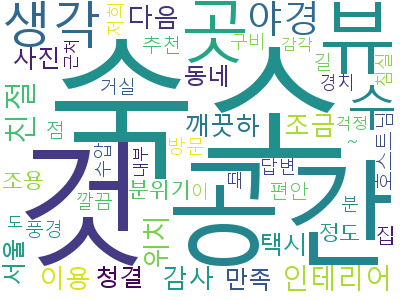

In [204]:
cloud.to_image()

In [205]:
def extract_pouns(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('p'):
                    yield lem

살짝의 오류는 어쩔 수 없다. ..이 붙어 있어서 오류가 남

In [206]:
from sklearn.feature_extraction.text import CountVectorizer

In [207]:
cv=CountVectorizer(max_features=100, tokenizer=extract_pouns)

In [208]:
tdm= cv.fit_transform(reviews.loc[0:100,'document'])

In [209]:
tdm.shape

(101, 100)

In [210]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [211]:
word_count.sort_values('빈도',ascending=False).head()

,단어,빈도
81,좋,99
78,있,77
0,가,45
97,하,31
72,오,30


In [212]:
word_count.to_excel('psmc-count.xlsx')

### 한국어 단어 구름 만들기

In [213]:
import pandas as pd
word_count =pd.read_excel('psmc-count.xlsx')

In [214]:
word_count.sort_values('빈도',ascending=False).head(10)

,Unnamed: 0,단어,빈도
81,81,좋,99
78,78,있,77
0,0,가,45
97,97,하,31
72,72,오,30


In [215]:
count_dic=word_count.set_index('단어')['빈도'].to_dict()

In [216]:
from wordcloud import WordCloud

In [217]:
wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)

In [218]:
cloud = wc.generate_from_frequencies(count_dic)

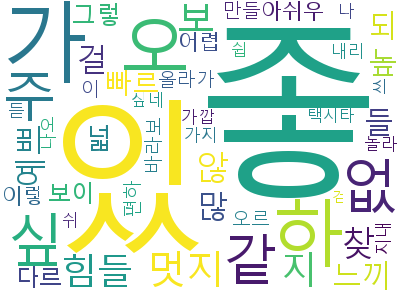

In [219]:
cloud.to_image()